<a href="https://colab.research.google.com/github/Tyfoods/3js-nn-visualizer/blob/master/docs/getting-started_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting started with `flybody`

<a target="_blank" href="https://colab.research.google.com/github/TuragaLab/flybody/blob/main/docs/getting-started.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<br>
<br>

`flybody` is an anatomically-detailed body model of the fruit fly _Drosophila melanogaster_ for MuJoCo physics simulator and reinforcement learning (RL) applications. The fly model was developed in a collaborative effort by Google DeepMind and HHMI Janelia Research Campus. We envision our model as a platform for fruit fly biophysics simulations and for modeling neural control of sensorimotor behavior in an embodied context.

This notebook presents several python examples of our MuJoCo fly model manipulations using `dm_control`.

For more background information, please explore:

* [MuJoCo documentation](https://mujoco.readthedocs.io/en/stable/overview.html)
* [MuJoCo](https://github.com/google-deepmind/mujoco) and tutorials therein
* [dm_control](https://github.com/google-deepmind/dm_control) and tutorials therein
* dm_control [paper](https://arxiv.org/abs/2006.12983)
* [PyMJCF](https://github.com/google-deepmind/dm_control/blob/main/dm_control/mjcf/README.md)

## Installing `flybody` on Colab
### _If running notebook locally, skip this cell!_

In [ ]:
# If in Colab, run this cell to install flybody. Don't forget to select GPU!!
# Otherwise, if running notebook locally, skip this cell.
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

!pip install --upgrade pip
!python -m pip install git+https://github.com/TuragaLab/flybody.git
!pip install numpy==2.0.2 --force-reinstall --quiet
os.kill(os.getpid(), 9)

# Configure MuJoCo to use the EGL rendering backend (requires GPU).
%env MUJOCO_GL=egl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Cloning https://github.com/TuragaLab/flybody.git to /tmp/pip-req-build-nbto6oc1
  Running command git clone --filter=blob:none --quiet https://github.com/TuragaLab/flybody.git /tmp/pip-req-build-nbto6oc1
  Resolved https://github.com/TuragaLab/flybody.git to commit e1a6135c310c39291f4fb68d682f2fd0b05e0555
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 164.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 114.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 124.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

# Imports

In [1]:
import os

# Set MuJoCo rendering backend to EGL (must be before mujoco import)
%env MUJOCO_GL=egl

import numpy as np
import matplotlib.pyplot as plt
import PIL.ImageDraw

from dm_control import mujoco
from dm_control import mjcf
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

import flybody
from flybody.fly_envs import walk_on_ball
from flybody.utils import display_video, any_substr_in_str

env: MUJOCO_GL=egl


In [2]:
# Frame size and camera name-to-idx mapping for rendering.
frame_size = {'width': 640, 'height': 480}
cameras = {'track1': 0, 'track2': 1, 'track3': 2,
           'back': 3, 'side': 4, 'bottom': 5, 'hero': 6,
           'eye_right': 7, 'eye_left': 8}

# Stand-alone fly model (outside of RL environment)

## Load the MuJoCo fly model
Let's load the fly model XML file `fruitfly.xml`, directly compile it to a `physics` object, and print some of the model's parameters. Note that in addition to the fly itself, the # of bodies includes one additional worldbody, joints include one freejoint connecting the fly with the worldbody, and the freejoint contributes six additional degrees of freedom (3 translation, 3 rotation).

In [3]:
flybody_path = os.path.dirname(flybody.__file__)
xml_path = os.path.join(flybody_path, 'fruitfly/assets/fruitfly.xml')

physics = mjcf.Physics.from_xml_path(xml_path)  # Load and compile.

print('# of bodies:', physics.model.nbody)
print('# of degrees of freedom:', physics.model.nv)
print('# of joints:', physics.model.njnt)
print('# of actuators:', physics.model.nu)
print("fly's mass (gr):", physics.model.body_subtreemass[1])

# of bodies: 68
# of degrees of freedom: 108
# of joints: 103
# of actuators: 78
fly's mass (gr): 0.0009846214691323193


## Visualize the fly as loaded
As initialized, the fly is in its default resting pose where all the joint angles stored in `physics.data.qpos` are set to zero. `physics.data.qpos` is a view onto the underlying MuJoCo's `mjData->qpos` data structure which holds the generalized coordinates of the model. Note that the entries `qpos[:3]` correspond to the Cartesian xyz position of the root freejoint in world coordinates, and `qpos[3:7]` is the quaternion representing the root joint orientation, initially set to unit quaternion `[1, 0, 0, 0]` by default. The rest of the elements `qpos[7:]` represent joint angles of all the hinge joints of our fly model.

In [4]:
physics.data.qpos

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

Visualizing several views from different cameras: "hero" and "bottom" cameras

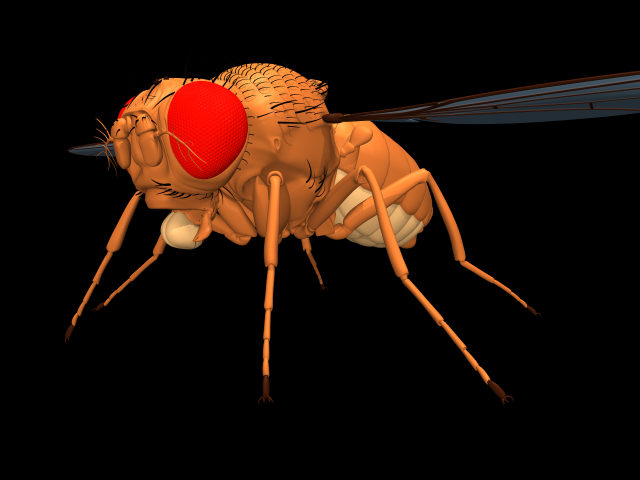

In [5]:
pixels = physics.render(camera_id=cameras['hero'], **frame_size)
PIL.Image.fromarray(pixels)

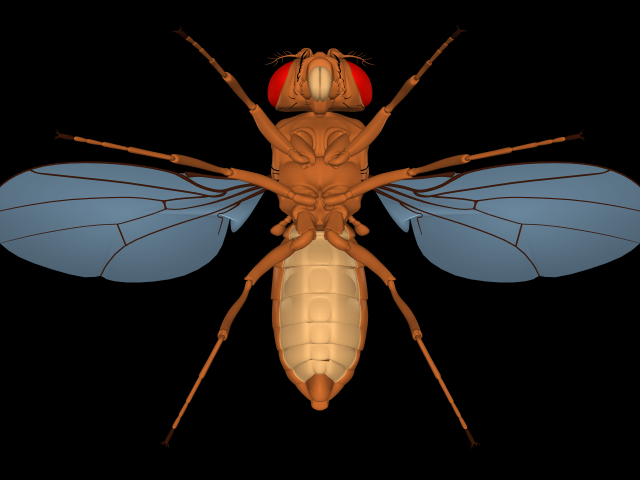

In [6]:
pixels = physics.render(camera_id=cameras['bottom'], **frame_size)
PIL.Image.fromarray(pixels)

We can hide the external cosmetic meshes and expose the collision geom primitives, shown in blue. Also notice the adhesive geoms shown in purple and ellipsoidal wing geoms used for fluid (air) interactions during flight simulation (orange).

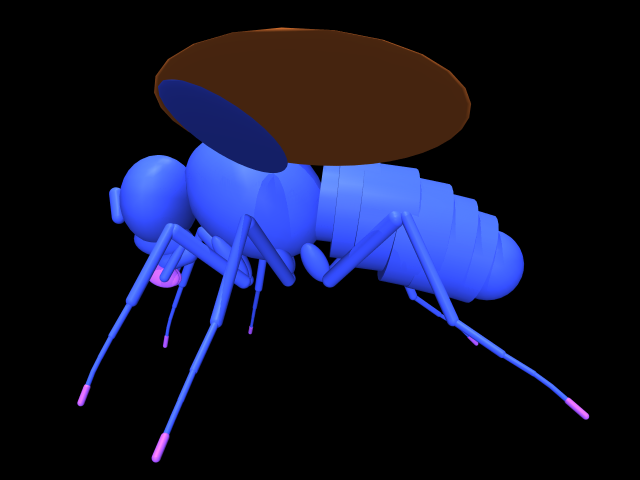

In [7]:
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.geomgroup[1] = 0  # Hide external meshes.
scene_option.geomgroup[3] = 1  # Make fluid-interactions wing ellipsoids visible (orange).
scene_option.geomgroup[4] = 1  # Make collision geoms visible (blue).
pixels = physics.render(camera_id=cameras['side'], **frame_size, scene_option=scene_option)
PIL.Image.fromarray(pixels)

## Load with floor and visualize
We can also load the fly model combined with a simple flat floor (and a skybox) to make more physically meaningful simulations

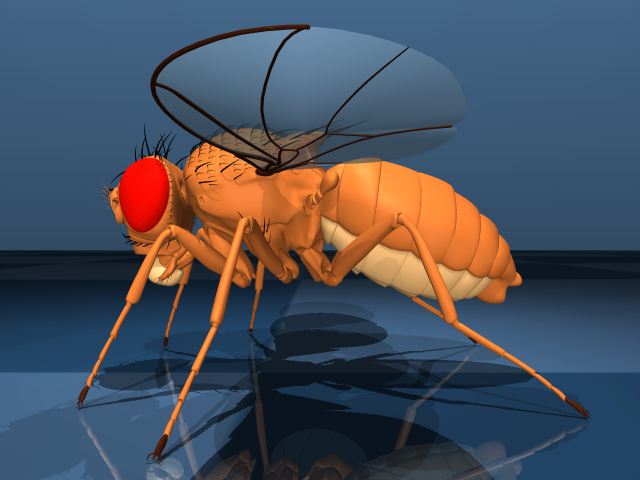

In [8]:
xml_path_floor = os.path.join(flybody_path, 'fruitfly/assets/floor.xml')
physics = mjcf.Physics.from_xml_path(xml_path_floor)

pixels = physics.render(camera_id=cameras['side'], **frame_size)
PIL.Image.fromarray(pixels)

## Kinematic manipulations
Let's try out a few simple kinematic manipulations with the fly model, i.e., without computing any forces yet, we'll put the body in several poses.

For example, we can start from the default rest position in the previous image and rotate the fly around the z-axis (vertical axis, points up) by a certain angle. This will require updating the root joint quaternion stored at `qpos[3:7]`.

For the purpose of kinematic manipulations, in addition to writing into `qpos`, we will have to update other position-related entries in MuJoCo's `mjData` data structure. One way of doing this is using `physics.reset_context()` (see [dm_control paper](https://arxiv.org/abs/2006.12983) for more detail).

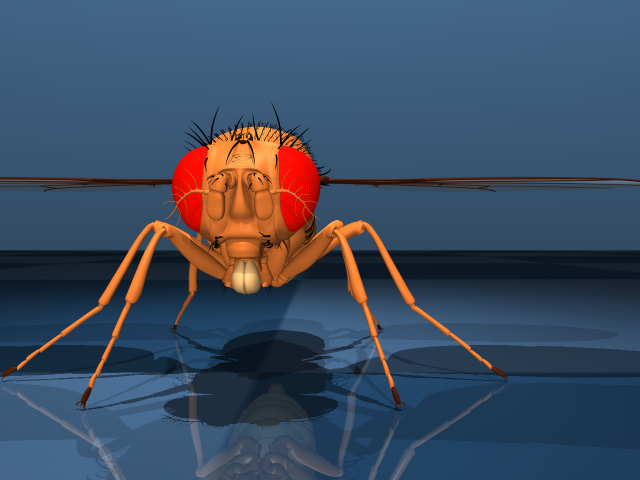

In [9]:
# Construct new root joint quaternion: 90 degree rotation around z-axis.
angle = np.pi / 2
quat = np.array([np.cos(angle/2), 0, 0, np.sin(angle/2)])
# Write into qpos and update other related quantities in mjData.
with physics.reset_context():
    physics.named.data.qpos[3:7] = quat
pixels = physics.render(camera_id=cameras['side'], **frame_size)
PIL.Image.fromarray(pixels)

Now we can try something a bit more involved.

Let's start from the default rest position again and try to fold the wings. In the model, each wing is connected to the thorax by three hinge joints (yaw, roll, pitch), effectively representing a 3-degree-of-freedom ball joint. We will need to find the wing joint angles corresponding to the folded wing position. This can be done as follows.

In addition to the actuators, most of the fly joints have weak springs attached to them. In the adsence of actuation or external forces, these springs will act to move the joints to specific pre-defined positions, such us folded wings, retracted legs for flight, holding the proboscis retracted, etc. In each case, these joint angle are stored in the joints' `springref` attribute in the XML file, and in the corresponding `qpos_spring` attribute in MuJoCo's `mjData` data structure, exposed as `physics.model.qpos_spring` through `dm_control` here.

Let's locate the wing joints and read the folded-wing joint angles from the spring parameters:

In [ ]:
wing_joints = []
folded_wing_angles = []
# Loop over all model joints.
for i in range(physics.model.njnt):
    joint_name = physics.model.id2name(i, 'joint')
    # If wing joint, store joint name and reference angle.
    if 'wing' in joint_name:
        wing_joints.append(joint_name)
        folded_wing_angles.append(
            physics.named.model.qpos_spring[joint_name].item())

wing_joints, folded_wing_angles

(['wing_yaw_left',
  'wing_roll_left',
  'wing_pitch_left',
  'wing_yaw_right',
  'wing_roll_right',
  'wing_pitch_right'],
 [1.5, 0.7, -1.0, 1.5, 0.7, -1.0])

Now we can write these wing angles into their corresponding fields in `qpos`. Note that we are now using named (and vectorized) indexing to write the wing angles to `qpos`.

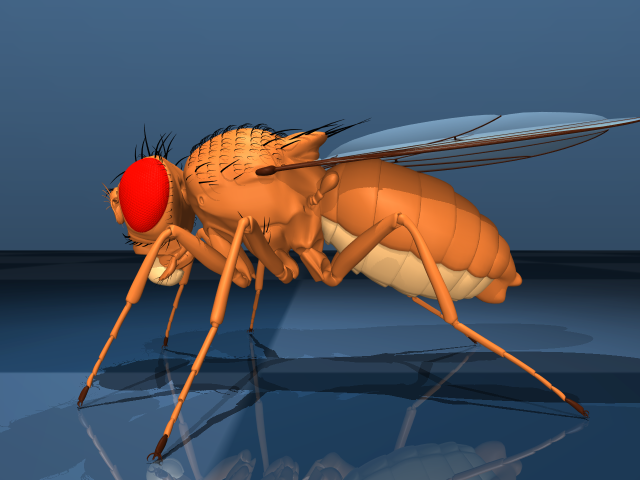

In [ ]:
with physics.reset_context():
    physics.named.data.qpos[wing_joints] = folded_wing_angles

pixels = physics.render(camera_id=cameras['side'], **frame_size)
PIL.Image.fromarray(pixels)

In the same way, we can (kinematically) put the legs into the retracted flight position, which is stored in `physics.model.qpos_spring`, as before:

In [1]:
with physics.reset_context():
    # Loop over all joints.
    for i in range(physics.model.njnt):
        name = physics.model.id2name(i, 'joint')
        # If leg joint, set the joint angle to be equal to its corresponding
        # reference spring angle.
        if any_substr_in_str(['coxa', 'femur', 'tibia', 'tarsus'], name):
            physics.named.data.qpos[name] = physics.named.model.qpos_spring[name]
    # Also, lift the fly by setting the z-coordinate of fly's root joint.
    physics.data.qpos[2] = 1.  # Here, units: cm.

pixels = physics.render(camera_id=cameras['side'], **frame_size)
PIL.Image.fromarray(pixels)

NameError: name 'physics' is not defined

## Kinematic replay: fold wings
Sequences of kinematically-set poses can be used for kinematic replay animations.

In this example, we will gradually move the wings from their default position to the folded position we obtained before. At each step we will render a frame and in the end generate a video from the sequence of frames:

In [ ]:
n_steps = 150
frames = []
for i in range(n_steps):
    with physics.reset_context():
        wing_angles = np.array(folded_wing_angles) * np.sin(np.pi/2 * i/n_steps)
        physics.named.data.qpos[wing_joints] = wing_angles
    pixels = physics.render(camera_id=cameras['back'], **frame_size)
    frames.append(pixels)

display_video(frames)

## Simulating physics: procedurally actuated body movements

Now we can try to run actual physical simulations.

In this example, we will procedurally control the fly's actuators and step the simulation in time to generate a sequence of movements. First, let's prepare groups of actuator names to control at each phase of the simulation. By convention, all the joint actuators in our model (in contrast to tendon actuators) have the same name as the joint they actuate.

In [ ]:
def get_leg_actuator_names(leg):
    return [f'{joint}_{leg}'
            for joint in ['coxa', 'femur', 'tibia', 'tarsus', 'tarsus2']]

# Names of leg actuators.
leg_actuators_L1 = get_leg_actuator_names('T1_left')
leg_actuators_R1 = get_leg_actuator_names('T1_right')
leg_actuators_L2 = get_leg_actuator_names('T2_left')

# Amplitudes of joint motion for front and middle legs.
amplitude_front = 0.5 * np.array([1, -1, 2, 1, 1])
amplitude_mid = 0.5 * np.array([0.5, -0.5, -2, 1, 2])

Now we can simulate the motion sequence. At each control step, we will be writing the control into MuJoCo's `mjData->ctrl`, exposed here as `physics.data.ctrl`. We will also engage the leg adhesion actuators at a certain point during the motion sequence.

The control semantics is the target joint angles for position actuators, and (scaled) force for force and adhesion actuators (see [MuJoCo docs](https://mujoco.readthedocs.io/en/stable/overview.html) for more details). With the exception of wings and adhesion, our model uses position actuators. The wings are powered by force (torque) actuators.

We will change the control once every `physics_to_ctrl_ratio == 10` simulation steps, to ensure simulation stability (see `dm_control` [paper](https://arxiv.org/abs/2006.12983) for more details).

Note that in the first part of the motion sequence, "Let wings fold", we don't alter `physics.data.ctrl` yet and it is still zero after resetting the simulation with `physics.reset()`. Nevertheless, the wings will fold -- this is achieved by the weak springs acting to move the wings to a reference position, as described above.

In [ ]:
n_steps = 100
physics_to_ctrl_ratio = 10
frames = []

# Reset physics to initial default state.
physics.reset()

# Let wings fold.
for i in range(n_steps):
    pixels = physics.render(camera_id=cameras['hero'], **frame_size)
    frames.append(pixels)
    for _ in range(physics_to_ctrl_ratio):
        physics.step()

# Twist head.
for i in range(n_steps):
    pixels = physics.render(camera_id=cameras['hero'], **frame_size)
    frames.append(pixels)
    physics.named.data.ctrl['head_twist'] = 1.5 * np.sin(2*np.pi * i/n_steps)
    for _ in range(physics_to_ctrl_ratio):
        physics.step()

# Move middle right leg.
for i in range(n_steps+50):
    if i <= n_steps:
        physics.named.data.ctrl[leg_actuators_L2] = amplitude_mid * np.sin(np.pi * i/n_steps)
    for _ in range(physics_to_ctrl_ratio):
        physics.step()
    pixels = physics.render(camera_id=cameras['hero'], **frame_size)
    frames.append(pixels)

# Activate middle leg adhision to prevent slipping when front legs are lifted later.
physics.named.data.ctrl[['adhere_claw_T2_right', 'adhere_claw_T2_left']] = 1.

# Lift fronts legs with lag.
for i in range(n_steps+100):
    left_angle = np.pi * i/n_steps
    right_angle = np.pi * i/n_steps - np.pi/5
    if left_angle <= np.pi:
        physics.named.data.ctrl[leg_actuators_L1] = amplitude_front * np.sin(left_angle)
    if 0 < right_angle <= np.pi:
        physics.named.data.ctrl[leg_actuators_R1] = amplitude_front * np.sin(right_angle)
    for _ in range(physics_to_ctrl_ratio):
        physics.step()
    pixels = physics.render(camera_id=cameras['hero'], **frame_size)
    frames.append(pixels)

display_video(frames)

## Actuate entire body with random actions
Now let's actuate all of the degrees of freedom at once with random control.

As force actuators (wings) and position actuators (the rest of the body) have different control semantics (scaled force and target joint angles, respectively), we'll actuate them with control signals of different magnitude. Let's find the indices for each actuator group first:

In [ ]:
wing_act_indices = []  # Force actuators.
body_act_indices = []  # Position actuators.
# Loop over all actuators.
for i in range(physics.model.nu):
    name = physics.model.id2name(i, 'actuator')
    # Store wing actuator indices and rest of indices separately.
    if 'wing' in name:
        wing_act_indices.append(i)
    else:
        body_act_indices.append(i)

print(wing_act_indices)
print(body_act_indices)

[14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]


Run simulation and actuate the fly body with random actions.

In [ ]:
n_body_actions = len(body_act_indices)
n_wing_actions = len(wing_act_indices)

n_steps = 300
physics_to_ctrl_ratio = 10
frames = []

# Reset simulatiomn to initial default state.
physics.reset()

for i in range(n_steps):
    pixels = physics.render(camera_id=cameras['side'], **frame_size)
    frames.append(pixels)
    physics.named.data.ctrl[body_act_indices] = np.random.uniform(-.3, .3, n_body_actions)
    physics.named.data.ctrl[wing_act_indices] = np.random.uniform(-.005, .005, n_wing_actions)
    for _ in range(physics_to_ctrl_ratio):
        physics.step()

display_video(frames)

## Model modifications: adding leg MoCap sites using [PyMJCF](https://github.com/google-deepmind/dm_control/blob/main/dm_control/mjcf/README.md)

In addition to manipulating joint angles and controls, as we did above, the fly model itself can be modified. All aspects of the model (e.g., sizes of body parts, actuator strengths and types, degrees of freedom, masses, appearance, etc.) can be easily changed programmatically.

Let's consider a simple example of fly body modifications. Assume we've got a motion capture dataset tracking the positions of the fly leg joints and we would like to fit the fly model's leg poses to this data. One way of doing so will require referencing the corresponding keypoint positions in the fly legs, which in turn can be achieved by adding sites to the leg joints.

In contrast to loading and compiling the model to a `physics` object in one step as we did before, we will split this process into two steps. First, we will load the fly model as `mjcf_model`, a python object model for the underlying MuJoCo fly XML file, which we can interact with and modify programmatically (see `dm_control`'s [PyMJCF](https://github.com/google-deepmind/dm_control/blob/main/dm_control/mjcf/README.md)). Second, we will compile the _modified_ `mjcf_model` to a `physics` object.

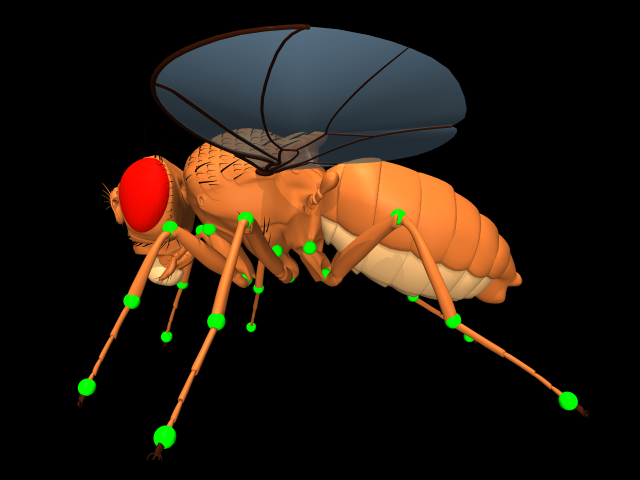

In [ ]:
# Site visualization parameters.
site_size = 3 * (0.005,)
site_rgba = (0, 1, 0, 1)

# Load MJCF model from the fly XML file.
mjcf_model = mjcf.from_path(xml_path)

# Make model modifications: add MoCap sites to legs. Don't compile model yet.

# Loop over bodies and add sites to position (0, 0, 0) in each body, which will
# correspond to leg joint locations.
for body in mjcf_model.find_all('body'):
    # If the body is a leg segment, add site to it.
    if any_substr_in_str(['coxa', 'femur', 'tibia', 'tarsus_', 'claw'], body.name):
        body.add('site', name=f'mocap_{body.name}', pos=(0, 0, 0),
                 size=site_size, group=0, rgba=site_rgba)

# The mjcf_model manipulations are complete, can compile now.
physics = mjcf.Physics.from_mjcf_model(mjcf_model)

pixels = physics.render(camera_id=cameras['side'], **frame_size)
PIL.Image.fromarray(pixels)

# Fly model in reinforcement learning environment

So far we've considered the fly model in a "bare" stand-alone configuration. One of the main applications of the model, however, is in the context of reinforcement learning (RL) environments -- training the fly to perform different tasks, such as locomotion and other behaviors.

`flybody` contains several ready-to-train RL environments, all of which can be created with a single line of code. Below we provide one simple example as a starting point.

The `composer` RL environment classes encapsulate the same fly model `physics` object we've seen before, and all our previous "bare fly model" examples and manipulations apply to RL environments just the same. As before, see [dm_control](https://github.com/google-deepmind/dm_control/) for more details on `composer` RL environments.

## Example: fly-on-ball RL environment

This RL task models a biological experimental setup where a tethered fruit fly is required to walk on a floating ball. The image below show an actual setup for such an experiment (_image credit: Igor Siwanowicz, HHMI Janelia Research Campus_).

To emulate this experimental setup, several task-specific modifications of the fly model would be required: (i) remove the root freejoint to fuse fly's thorax with the world to imitate tethering, (ii) replace the flat floor with a ball, and (iii) add an artificial observable to allow the policy to observe the rotational state of the ball. The ball position is fixed underneath the tethered fly, but it is free to rotate if a sufficient force is applied by fly's leg. The goal of the RL task is to train a policy to control the legs such that the ball rotates in a particular direction and at a particular speed.

See [task implementation](https://github.com/TuragaLab/flybody/blob/main/flybody/tasks/walk_on_ball.py) for details on the task-specific fly model modifications, reward caclulation, and RL environment step logic.

![fly-on-ball.jpg](attachment:fba018f9-7e55-4b53-a3a9-490a8b65384d.jpg)

The task environment can be created with the following convenient one-liner:

In [ ]:
env = walk_on_ball()

We can inspect the RL environment and see the observations (policy inputs) and the actions (policy outputs). Note the extra observable `ball_qvel` we added specifically for this task. It measures the angular velocity of the ball rotation.

In [ ]:
env.observation_spec()

OrderedDict([('walker/accelerometer',
              Array(shape=(3,), dtype=dtype('float64'), name='walker/accelerometer')),
             ('walker/actuator_activation',
              Array(shape=(59,), dtype=dtype('float64'), name='walker/actuator_activation')),
             ('walker/appendages_pos',
              Array(shape=(21,), dtype=dtype('float64'), name='walker/appendages_pos')),
             ('walker/force',
              Array(shape=(18,), dtype=dtype('float64'), name='walker/force')),
             ('walker/gyro',
              Array(shape=(3,), dtype=dtype('float64'), name='walker/gyro')),
             ('walker/joints_pos',
              Array(shape=(85,), dtype=dtype('float64'), name='walker/joints_pos')),
             ('walker/joints_vel',
              Array(shape=(85,), dtype=dtype('float64'), name='walker/joints_vel')),
             ('walker/touch',
              Array(shape=(6,), dtype=dtype('float64'), name='walker/touch')),
             ('walker/velocimeter',
       

Action specifications: shape, data type, action names, and minima and maxima of the control ranges

In [ ]:
env.action_spec()

BoundedArray(shape=(59,), dtype=dtype('float64'), name='adhere_claw_T1_left\tadhere_claw_T1_right\tadhere_claw_T2_left\tadhere_claw_T2_right\tadhere_claw_T3_left\tadhere_claw_T3_right\thead_abduct\thead_twist\thead\tabdomen_abduct\tabdomen\tcoxa_abduct_T1_left\tcoxa_twist_T1_left\tcoxa_T1_left\tfemur_twist_T1_left\tfemur_T1_left\ttibia_T1_left\ttarsus_T1_left\ttarsus2_T1_left\tcoxa_abduct_T1_right\tcoxa_twist_T1_right\tcoxa_T1_right\tfemur_twist_T1_right\tfemur_T1_right\ttibia_T1_right\ttarsus_T1_right\ttarsus2_T1_right\tcoxa_abduct_T2_left\tcoxa_twist_T2_left\tcoxa_T2_left\tfemur_twist_T2_left\tfemur_T2_left\ttibia_T2_left\ttarsus_T2_left\ttarsus2_T2_left\tcoxa_abduct_T2_right\tcoxa_twist_T2_right\tcoxa_T2_right\tfemur_twist_T2_right\tfemur_T2_right\ttibia_T2_right\ttarsus_T2_right\ttarsus2_T2_right\tcoxa_abduct_T3_left\tcoxa_twist_T3_left\tcoxa_T3_left\tfemur_twist_T3_left\tfemur_T3_left\ttibia_T3_left\ttarsus_T3_left\ttarsus2_T3_left\tcoxa_abduct_T3_right\tcoxa_twist_T3_right\tcoxa_

Let's reset the RL environment and visualize the initial state: the fly is stationary in its default pose, the wings are folded, and the ball is not rotating. This would be the initial state of a training episode or inference on a trained policy.

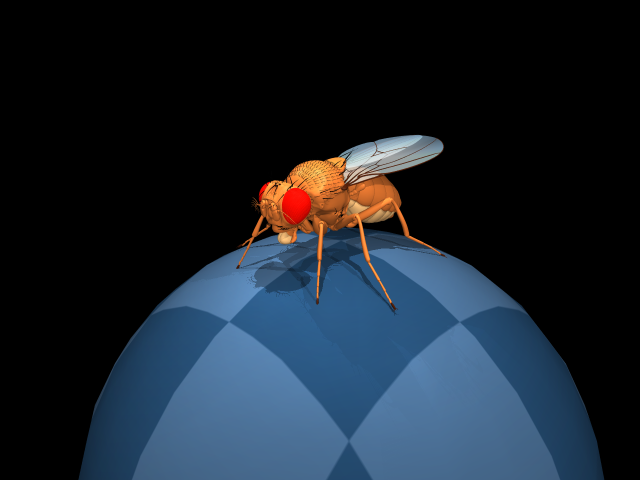

In [ ]:
timestep = env.reset()

pixels = env.physics.render(camera_id=cameras['track1'], **frame_size)
PIL.Image.fromarray(pixels)

## Run episode with random actions

Let's run a short episode with a dummy policy outputting random actions. As we run the environment loop we'll render frames and, for the sake of example, collect the reward at each time step.

In [ ]:
n_actions = env.action_spec().shape[0]

def random_action_policy(observation):
    del observation  # Not used by dummy policy.
    random_action = np.random.uniform(-.5, .5, n_actions)
    return random_action

frames = []
rewards = []

# Environment loop.
timestep = env.reset()
for _ in range(200):

    action = random_action_policy(timestep.observation)
    timestep = env.step(action)
    rewards.append(timestep.reward)

    pixels = env.physics.render(camera_id=cameras['track1'], **frame_size)
    frames.append(pixels)

display_video(frames)

In [ ]:
plt.plot(rewards)
plt.xlabel('timestep')
plt.ylabel('reward')

Text(0, 0.5, 'reward')